In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


In [3]:
train_dir = "C:/Users/raiya/Desktop/ip102_v1.1/train"
val_dir = "C:/Users/raiya/Desktop/ip102_v1.1/val"
test_dir = "C:/Users/raiya/Desktop/ip102_v1.1/test"

In [4]:
model = VGG19(include_top=False,input_shape=(224, 224, 3), weights='imagenet')
input_shape = (224,224)

In [5]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.01,
                                  zoom_range=[0.6, 1.4],
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 32

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                                 
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 45094 images belonging to 102 classes.
Found 7507 images belonging to 102 classes.
Found 22618 images belonging to 102 classes.


In [7]:
import os
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

cls_train = generator_train.classes
cls_test = generator_test.classes


class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
num_classes

102

In [8]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool


In [9]:
transfer_layer = model.get_layer('block5_pool')
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [10]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.3))
#new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [11]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

# steps_per_epoch = 20
# steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1409/1409 [==============================] - 600s 401ms/step - loss: 3.4500 - categorical_accuracy: 0.2324 - val_loss: 2.6586 - val_categorical_accuracy: 0.3685
Epoch 2/30
1409/1409 [==============================] - 565s 401ms/step - loss: 2.6340 - categorical_accuracy: 0.3743 - val_loss: 2.2651 - val_categorical_accuracy: 0.4488
Epoch 3/30
1409/1409 [==============================] - 564s 400ms/step - loss: 2.2977 - categorical_accuracy: 0.4362 - val_loss: 2.0542 - val_categorical_accuracy: 0.4934
Epoch 4/30
1409/1409 [==============================] - 569s 404ms/step - loss: 2.0669 - categorical_accuracy: 0.4793 - val_loss: 1.8681 - val_categorical_accuracy: 0.5309
Epoch 5/30
1409/1409 [==============================] - 567s 402ms/step - loss: 1.9079 - categorical_accuracy: 0.5111 - val_loss: 1.7617 - val_categorical_accuracy: 0.5540
Epoch 6/30
1409/1409 [==============================] - 556s 394ms/step - loss: 1.7739 - categorical_accuracy: 0.5375 - val_loss: 1.7474 - v

In [13]:
steps_val = generator_val.n / batch_size
y_pred = new_model.predict_generator(generator_train,steps = steps_val)
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[39 12 49 ... 94 24 70]


In [14]:
result = new_model.evaluate_generator(generator_test, steps=steps_val)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test-set classification accuracy: 69.14%


In [15]:
result = new_model.evaluate_generator(generator_val, steps=steps_val)
print("Training-set classification accuracy: {0:.2%}".format(result[1]))

Training-set classification accuracy: 65.58%


In [16]:
new_model.save('C:/Users/raiya/Desktop/ip102_v1.1/VGG19_ip102_v1.1.h5')

In [17]:
y_pred = new_model.predict_generator(generator_val,steps = steps_val)

In [18]:
y_pred

array([[8.618e-01, 1.141e-02, 7.480e-05, ..., 3.576e-07, 5.960e-08,
        0.000e+00],
       [1.000e+00, 1.398e-04, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.852e-01, 8.206e-04, 1.663e-05, ..., 1.192e-07, 0.000e+00,
        5.960e-08],
       ...,
       [6.557e-07, 2.980e-07, 3.225e-05, ..., 1.013e-06, 0.000e+00,
        6.030e-01],
       [9.537e-07, 4.172e-07, 1.085e-05, ..., 7.749e-07, 8.076e-05,
        5.164e-02],
       [4.768e-06, 1.609e-06, 4.411e-06, ..., 1.944e-04, 1.490e-06,
        9.686e-02]], dtype=float16)

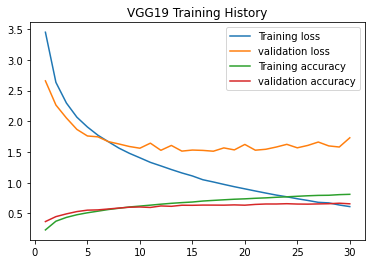

In [19]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
acc_train = history.history['categorical_accuracy']
acc_val = history.history['val_categorical_accuracy']
epochs = range(1, 31)
plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='validation loss')
plt.plot(epochs, acc_train, label='Training accuracy')
plt.plot(epochs, acc_val, label='validation accuracy')
plt.title('VGG19 Training History')
plt.legend()
plt.show()

In [1]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    image = image.resize((224, 224))
    img = np.asarray(image)
    img = img/255
    print(img.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img, model.predict, top_labels=4, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))

In [2]:
new_model1 = tf.keras.models.load_model('F:/ip102_v1.1/VGG19_ip102_v1.1.h5')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

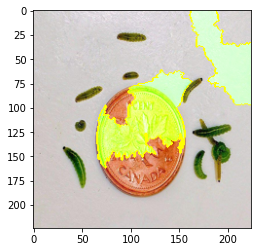

In [3]:
xAI(new_model1, "F:/ip102_v1.1/test_alfalfa/44/30385.jpg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

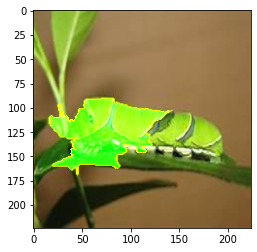

In [4]:
xAI(new_model1, "F:/ip102_v1.1/test_citrus/73/58450.jpg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

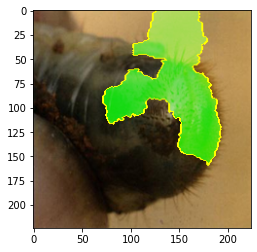

In [5]:
xAI(new_model1, "F:/ip102_v1.1/test_corn/14/09207.jpg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

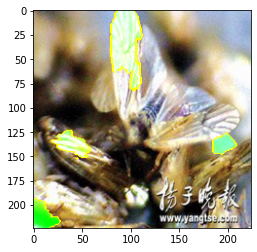

In [6]:
xAI(new_model1, "F:/ip102_v1.1/test_rice/7/04482.jpg")

(224, 224, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

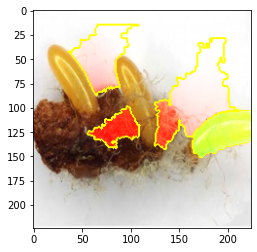

In [7]:
xAI(new_model1, "F:/ip102_v1.1/test_vitis/57/40732.jpg")

In [30]:
new_model1 = tf.keras.models.load_model('C:/Users/raiya/Desktop/ip102_v1.1/VGG19_ip102_v1.1.h5')

In [34]:
test_true_dir = "C:/Users/raiya/Desktop/ip102_v1.1/valext"

In [ ]:
datagen_test_true_dir = ImageDataGenerator(rescale=1./255)

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
generator_test_true_dir = datagen_test_true_dir.flow_from_directory(directory=test_true_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 170 images belonging to 1 classes.


In [ ]:
steps_test_true_dir = generator_test_true_dir.n / batch_size

In [ ]:
y_pred = new_model.predict_generator(generator_test_true_dir,steps = steps_test_true_dir)

In [ ]:
y_pred

array([[2.6123e-02, 9.7363e-01],
       [1.1921e-07, 1.0000e+00],
       [2.9778e-04, 9.9951e-01],
       [1.6689e-06, 1.0000e+00],
       [0.0000e+00, 1.0000e+00],
       [4.3571e-05, 1.0000e+00],
       [2.8839e-02, 9.7119e-01],
       [1.3222e-02, 9.8682e-01],
       [7.1487e-03, 9.9268e-01],
       [0.0000e+00, 1.0000e+00],
       [8.0729e-04, 9.9902e-01],
       [3.1605e-03, 9.9707e-01],
       [3.7956e-03, 9.9609e-01],
       [6.2622e-02, 9.3750e-01],
       [4.8280e-06, 1.0000e+00],
       [5.6006e-01, 4.3970e-01],
       [1.6356e-03, 9.9854e-01],
       [6.8512e-03, 9.9316e-01],
       [6.6797e-01, 3.3203e-01],
       [2.2650e-06, 1.0000e+00],
       [5.4359e-05, 1.0000e+00],
       [7.7344e-01, 2.2668e-01],
       [4.4861e-03, 9.9561e-01],
       [1.5235e-04, 1.0000e+00],
       [1.6689e-06, 1.0000e+00],
       [1.4353e-03, 9.9854e-01],
       [4.0344e-02, 9.5947e-01],
       [2.0313e-03, 9.9805e-01],
       [2.5806e-03, 9.9756e-01],
       [0.0000e+00, 1.0000e+00],
       [8.

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0]


In [ ]:
result = new_model.evaluate_generator(generator_test_true_dir,steps = steps_test_true_dir)

In [ ]:
print("Recall: {0:.2%}".format(1 - result[1]))

Recall: 90.00%


In [ ]:
true_positive = 153

In [ ]:
test_false_dir = "C:/Users/raiya/Desktop/ip102_v1.1/valext"

In [ ]:
datagen_test_false_dir = ImageDataGenerator(rescale=1./255)

In [ ]:
generator_test_false_dir = datagen_test_false_dir.flow_from_directory(directory=test_false_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 314 images belonging to 1 classes.


In [ ]:
steps_test_false_dir = generator_test_false_dir.n / batch_size

In [ ]:
y_pred = new_model.predict_generator(generator_test_false_dir,steps = steps_test_false_dir)

In [ ]:
y_pred

array([[9.9951e-01, 4.3726e-04],
       [9.7949e-01, 2.0691e-02],
       [9.8291e-01, 1.7136e-02],
       [9.5166e-01, 4.8462e-02],
       [7.0752e-01, 2.9248e-01],
       [9.9756e-01, 2.2697e-03],
       [9.8145e-01, 1.8784e-02],
       [9.9951e-01, 3.4809e-04],
       [9.2627e-01, 7.3669e-02],
       [9.9121e-01, 8.7585e-03],
       [9.9902e-01, 7.7629e-04],
       [2.0068e-01, 7.9932e-01],
       [9.9512e-01, 4.8294e-03],
       [9.9902e-01, 8.7976e-04],
       [9.9902e-01, 8.0395e-04],
       [9.9854e-01, 1.3723e-03],
       [4.2798e-01, 5.7227e-01],
       [9.8389e-01, 1.6159e-02],
       [9.9854e-01, 1.6870e-03],
       [9.9854e-01, 1.2398e-03],
       [9.9902e-01, 1.1854e-03],
       [9.9756e-01, 2.4052e-03],
       [9.9902e-01, 9.8133e-04],
       [9.9707e-01, 2.6989e-03],
       [9.9805e-01, 1.7414e-03],
       [1.8030e-01, 8.1982e-01],
       [9.9902e-01, 9.4366e-04],
       [9.9609e-01, 3.7651e-03],
       [9.9805e-01, 2.0714e-03],
       [8.4375e-01, 1.5601e-01],
       [9.

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [ ]:
false_positive = 16

In [ ]:
print("Precision: {0:.2%}".format(true_positive/(true_positive+false_positive)))

Precision: 90.53%


In [ ]:
print("F1 Score: {0:.2%}".format((2*.9*.953)/(.9+.953)))

F1 Score: 92.57%
